In [2]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return 3*x**2 -4*x + 5

In [6]:
f(2)

9

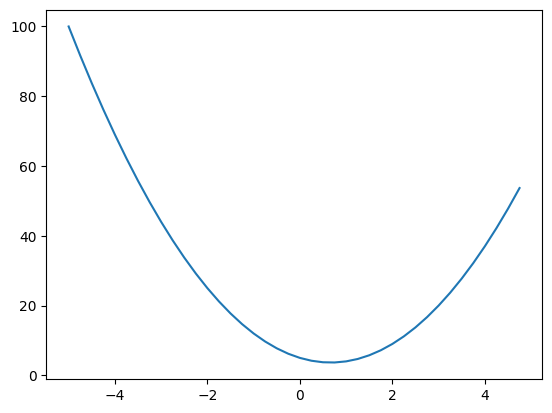

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [12]:
h = 0.0001
x = 2 / 3
(f(x + h) - f(x)) / h

0.0002999999981767587

In [13]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [16]:
h = 0.0001

#Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print(d1, d2)
print((d2 - d1) / h)

4.0 4.0001
0.9999999999976694


In [124]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label='K')
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label='K')
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        tanh = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tanh, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - tanh**2) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
    

In [41]:
a = Value(2.0, label='a') 
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')

L = d * f; L.label='L'

In [42]:
d.data, d._prev, d._op

(4.0, {Value(data=-6.0), Value(data=10.0)}, '+')

In [46]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any Value object in the graph; create a rectangular ('record') node for it. 
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}"%(n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it.
            dot.node(name=uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # Connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot
        

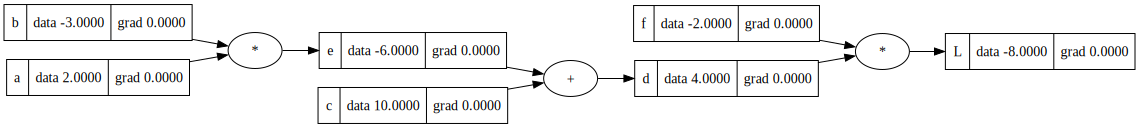

In [51]:
draw_dot(L)

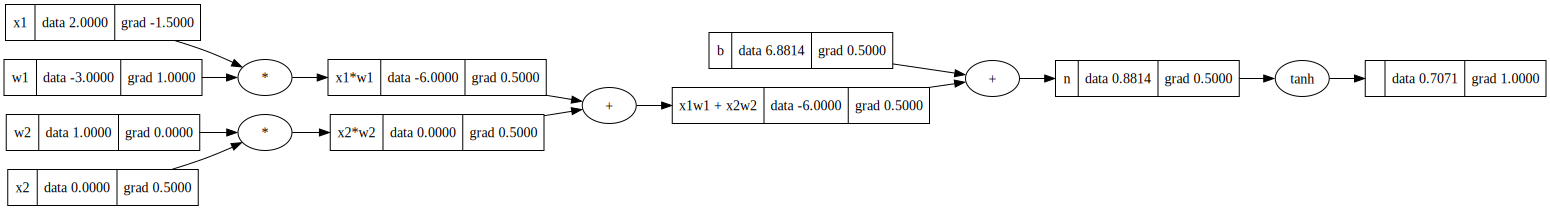

In [93]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137358, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label='n'

o = n.tanh()
o.backward()

draw_dot(o)

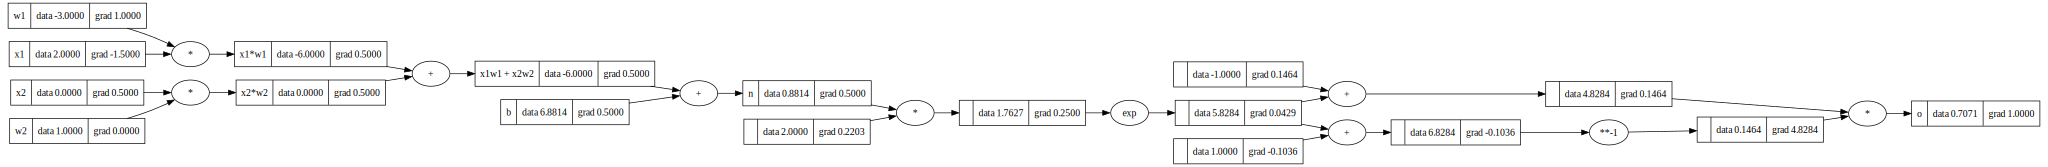

In [94]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137358, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label='n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

In [96]:
import random

In [140]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
        
    
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
o = n(x)

        

In [141]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9164059125888228),
 Value(data=0.8602970873008977),
 Value(data=0.8312127028904348),
 Value(data=0.9357280891006612)]

In [155]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print(loss)

Value(data=6.825164066228256)


In [153]:
loss.backward()
loss.label = 'loss'

In [144]:
n.layers[0].neurons[0].w[0].grad

0.5687587857592638

In [146]:
len(n.parameters())

41

In [154]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [203]:
for _ in range(200):
    # Forward Pass
    ypred = [n(x) for x in xs]
    print(ypred)

    # Backward Pass
    for p in n.parameters():
        p.grad = 0.0
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
    print("Loss is ", loss)
    loss.backward()

    # Update
    for node in n.parameters():
        node.data += -0.01 * node.grad 
print(list(zip(ys, ypred)))

[Value(data=0.9999999999159569), Value(data=-0.9852869176318304), Value(data=-1.0), Value(data=0.9999999999159499)]
Loss is  Value(data=0.000216474792772543)
[Value(data=0.9999999999159568), Value(data=-0.9856162773337368), Value(data=-1.0), Value(data=0.9999999999159499)]
Loss is  Value(data=0.0002068914777399737)
[Value(data=0.9999999999159568), Value(data=-0.9859239428864486), Value(data=-1.0), Value(data=0.9999999999159499)]
Loss is  Value(data=0.00019813538386396156)
[Value(data=0.9999999999159567), Value(data=-0.9862122163698562), Value(data=-1.0), Value(data=0.9999999999159498)]
Loss is  Value(data=0.00019010297743166047)
[Value(data=0.9999999999159567), Value(data=-0.9864830699324567), Value(data=-1.0), Value(data=0.9999999999159498)]
Loss is  Value(data=0.00018270739845085578)
[Value(data=0.9999999999159567), Value(data=-0.9867382044320269), Value(data=-1.0), Value(data=0.9999999999159498)]
Loss is  Value(data=0.00017587522168671185)
[Value(data=0.9999999999159566), Value(data

In [196]:
#